X.shape: (400, 16, 16, 16, 1)
y.shape: (400,)


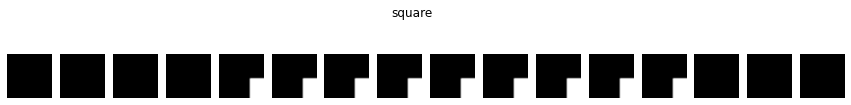

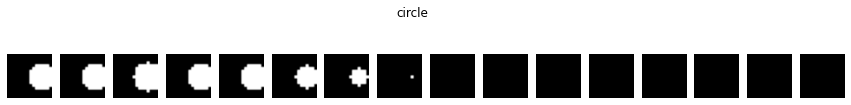

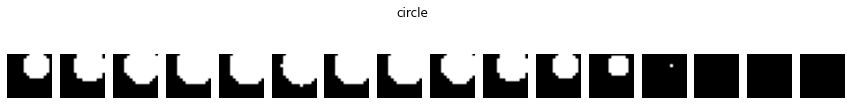

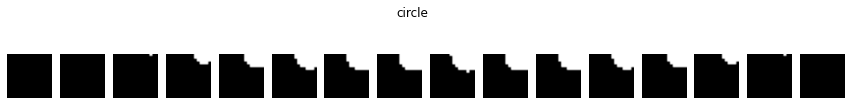

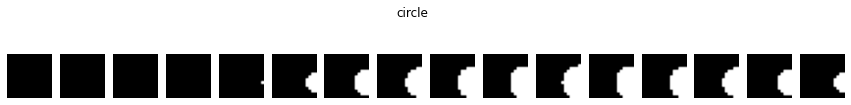

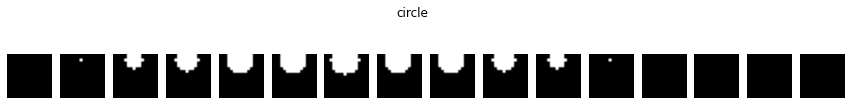

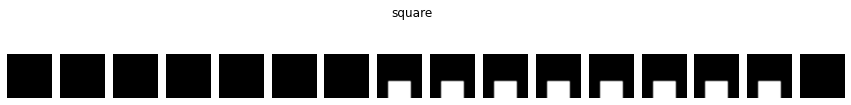

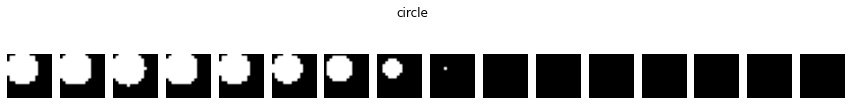

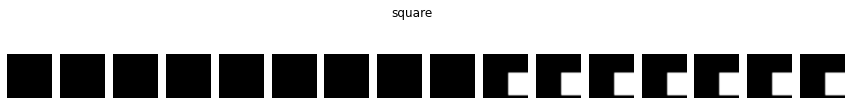

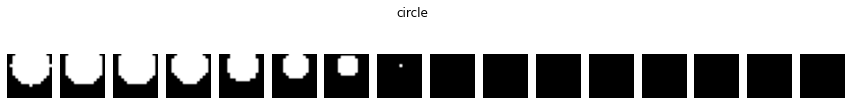

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder
from typing import Tuple


np.random.seed(42)

def generate_square(shape: Tuple[int] = (16, 16, 16)) -> np.ndarray:
    img = np.zeros(shape)
    corner = np.asarray(shape) // 4 + np.random.randint(0, shape[0] // 2, 3)
    side = np.random.randint(shape[1] / 3, shape[1] * 2 / 3)
    
    idx = np.asarray(np.meshgrid(*[np.arange(side) for _ in range(3)])).T.reshape(-1, 3)
    idx += corner
    maxes = np.amax(idx, axis=-1)
    idx = idx[maxes < shape[0]]
    
    img[tuple(idx.T)] = 1
    
    return img

def generate_circle(shape: Tuple[int] = (16, 16, 16)) -> np.ndarray:
    img = np.zeros(shape)
    center = np.random.randint(0, shape[0], 3)
    radius = np.random.randint(shape[0] // 4, shape[0] // 2)

    idx = np.asarray(np.meshgrid(*[np.arange(x) for x in shape])).T.reshape(-1, 3)
    distances = euclidean_distances(idx, center.reshape(1, -1))[:,0]
    inside = distances <= radius
    
    img[tuple(idx[inside].T)] = 1
    
    return img

n = 200
shape = 16
squares = np.asarray([generate_square(shape=(shape, shape, shape)) for _ in range(n)])
circles = np.asarray([generate_circle(shape=(shape, shape, shape)) for _ in range(n)])
X = np.concatenate([squares, circles], axis=0)
y = np.asarray((['square'] * n) + (['circle'] * n))
idx = np.random.permutation(np.arange(len(X)))
X = np.reshape(X, (-1, shape, shape, shape, 1))
X = X[idx]
y = y[idx]

print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

for i in range(10):
    fig, ax = plt.subplots(1, shape, figsize=(15, 2))
    fig.suptitle(y[i])
    for j in range(shape):
        ax[j].imshow(X[i,j], cmap='Greys_r')
        ax[j].axis('off')
    plt.show()

encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

train_X = X[:300]
train_y = y[:300]
test_X = X[:300]
test_y = y[:300]

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv3D, Dense, Dropout, \
                                    GlobalAveragePooling3D, Input, MaxPooling3D, Reshape
from tensorflow.keras.optimizers import Adam

input = Input((shape, shape, shape, 1))
x = input

x = Conv3D(8, (3, 3, 3), padding='SAME', activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2))(x)

x = Conv3D(16, (3, 3, 3), padding='SAME', activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2))(x)

x = Conv3D(32, (3, 3, 3), padding='SAME', activation=None)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling3D((2, 2, 2))(x)

x = GlobalAveragePooling3D()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(input, x)

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=32, epochs=100)

2022-03-11 23:19:13.763170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 23:19:13.770276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 23:19:13.770600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 23:19:13.771801: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-03-11 23:19:15.362118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-03-11 23:19:15.548745: W tensorflow/stream_executor/gpu/asm_compiler.cc:113] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.


10/10 [==============================] - 2s 26ms/step - loss: 1.0141 - accuracy: 0.5333 - val_loss: 0.6696 - val_accuracy: 0.5533
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8209 - accuracy: 0.6267 - val_loss: 0.6562 - val_accuracy: 0.7800
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 0.7753 - accuracy: 0.6833 - val_loss: 0.6462 - val_accuracy: 0.8300
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.6700 - accuracy: 0.6933 - val_loss: 0.6391 - val_accuracy: 0.7633
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.6635 - accuracy: 0.7100 - val_loss: 0.6336 - val_accuracy: 0.7200
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.7294 - accuracy: 0.6933 - val_loss: 0.6268 - val_accuracy: 0.6933
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 0.5383 - accuracy: 0.7667 - val_loss: 0.6231 - val_accuracy: 0.6500
Epoch 8/100
10/10 [=====

Epoch 59/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0315 - accuracy: 0.9900 - val_loss: 0.0281 - val_accuracy: 1.0000
Epoch 60/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0310 - accuracy: 0.9967 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 61/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0369 - accuracy: 0.9967 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 62/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 63/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 64/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0267 - accuracy: 0.9933 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 65/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0196 - accuracy: 0.9967 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 

In [3]:
from explainability import LayerwiseRelevancePropagator


explainers = {
    encoder.categories_[0][0]: LayerwiseRelevancePropagator(model, layer=17, idx=0),
    encoder.categories_[0][1]: LayerwiseRelevancePropagator(model, layer=17, idx=1)
}

ValueError: in user code:

    /home/esten/repos/keras-explainability/explainability/layers/layer.py:66 call  *
        R = tf.multiply(a, c)
    /home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:530 multiply
        return gen_math_ops.mul(x, y, name)
    /home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:6246 mul
        "Mul", x=x, y=y, name=name)
    /home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:601 _create_op_internal
        compute_device)
    /home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3569 _create_op_internal
        op_def=op_def)
    /home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2042 __init__
        control_input_ops, op_def)
    /home/esten/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 16 and 32 for '{{node 9/Mul_1}} = Mul[T=DT_FLOAT](Placeholder, 9/conv3d_transpose)' with input shapes: [?,4,4,4,16], [1,4,4,4,32].


In [ ]:
img = test_X[0]
label = encoder.categories_[0][np.argmax(test_y[0])]

fig, ax = plt.subplots(1, shape, figsize=(15, 2))
fig.suptitle(f'Image {label}')
for i in range(shape):
    ax[i].imshow(img[i], cmap='Greys_r')
    ax[i].axis('off')
plt.show()

print(img.shape)
model.predict(test_X[:32])

for classname in ['square', 'circle']:
    explanation = explainers[classname].predict(test_X[:1])
    
    fig, ax = plt.subplots(1, shape, figsize=(15, 2))
    fig.suptitle(f'{classname} explanation')
    for i in range(shape):
        ax[i].imshow(explanation[0,i], cmap='seismic')
        ax[i].axis('off')
    plt.show()


In [ ]:
explainers['square'].summary()